In [4]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D

In [2]:


def build_CNN(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv1', input_shape=input_shape, padding="same"))
    model.add(Conv2D(10, (3, 3), activation='relu', name='conv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(8,8), activation="relu", name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    # model.add(Conv2D(1, (1,1), name="dense2", activation="tanh")) # This was Dense(1)
    model.add(Dense(1, activation="tanh"))
    if filename:
        model.load_weights(filename)
    return model


Using TensorFlow backend.


In [3]:
model = build_CNN()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
import glob
import cv2

In [5]:
# load training data
wallies = glob.glob("Data/64/waldo/*.jpg")
not_wallies = glob.glob("Data/64/notwaldo/*.jpg")

In [6]:
Y = np.concatenate([np.ones(len(wallies)), np.zeros(len(not_wallies))-1])

X = []
for name in wallies:    
    X.append(cv2.resize(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB),(299,299)))
for name in not_wallies:    
    X.append(cv2.resize(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB),(299,299)))
X = np.array(X)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  X.shape[1:]

X_train shape: (4838, 64, 64, 3)
4838 train samples
538 test samples


In [23]:
from keras.layers import Flatten

In [24]:
model = build_CNN(input_shape=input_shape)
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

In [25]:
model.fit(X_train, Y_train, batch_size=100, epochs=15, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 4838 samples, validate on 538 samples
Epoch 1/15
4838/4838 [==============================] - 15s 3ms/step - loss: 0.0430 - acc: 0.9731 - val_loss: 0.0446 - val_acc: 0.9888
Epoch 2/15
4838/4838 [==============================] - 16s 3ms/step - loss: 0.0273 - acc: 0.9932 - val_loss: 0.0446 - val_acc: 0.9888
Epoch 3/15
4838/4838 [==============================] - 13s 3ms/step - loss: 0.0273 - acc: 0.9932 - val_loss: 0.0446 - val_acc: 0.9888
Epoch 4/15
4838/4838 [==============================] - 15s 3ms/step - loss: 0.0273 - acc: 0.9932 - val_loss: 0.0446 - val_acc: 0.9888
Epoch 5/15
4838/4838 [==============================] - 16s 3ms/step - loss: 0.0273 - acc: 0.9932 - val_loss: 0.0446 - val_acc: 0.9888
Epoch 6/15
4838/4838 [==============================] - 16s 3ms/step - loss: 0.0273 - acc: 0.9932 - val_loss: 0.0446 - val_acc: 0.9888
Epoch 7/15
4838/4838 [==============================] - 13s 3ms/step - loss: 0.0273 - acc: 0.99

In [30]:
model.save_weights("wally.h5")
testmodel = build_CNN(input_shape=(None,None,3), filename="wally.h5")

In [38]:
def locate():
    data = cv2.cvtColor(cv2.imread('Data/original-images/3.jpg'), cv2.COLOR_BGR2RGB)
    
    heatmap = testmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    plt.figure(figsize=(16, 10))
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Potential Wally matches")
    plt.figure(figsize=(16, 10))
    plt.show()
    maximum = np.max(heatmap)
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]> maximum - 0.0001])
    y = (yy[heatmap[0,:,:,0]>maximum - 0.0001])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

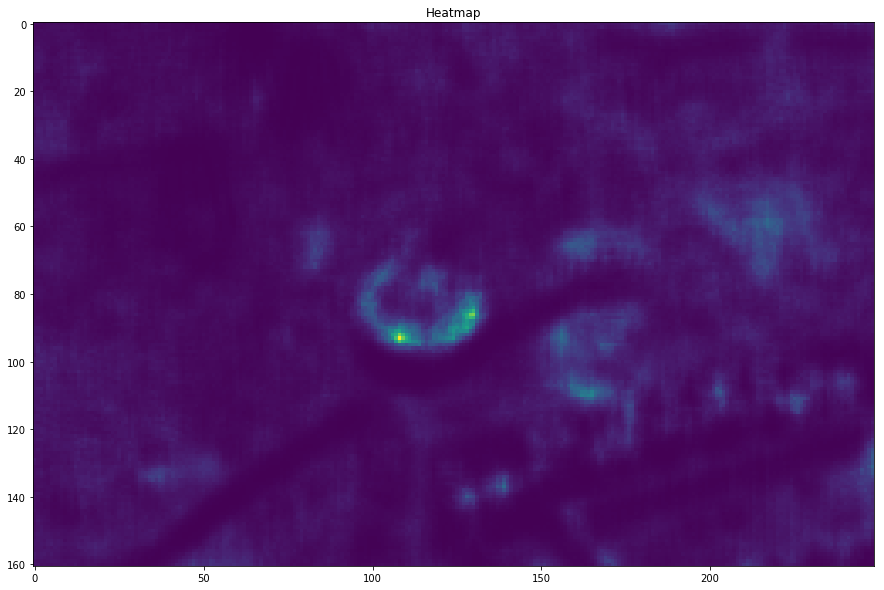

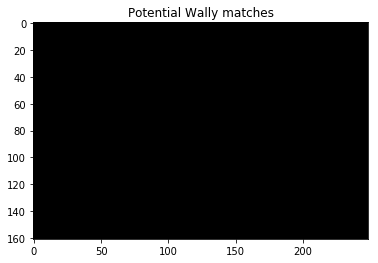

<Figure size 1152x720 with 0 Axes>

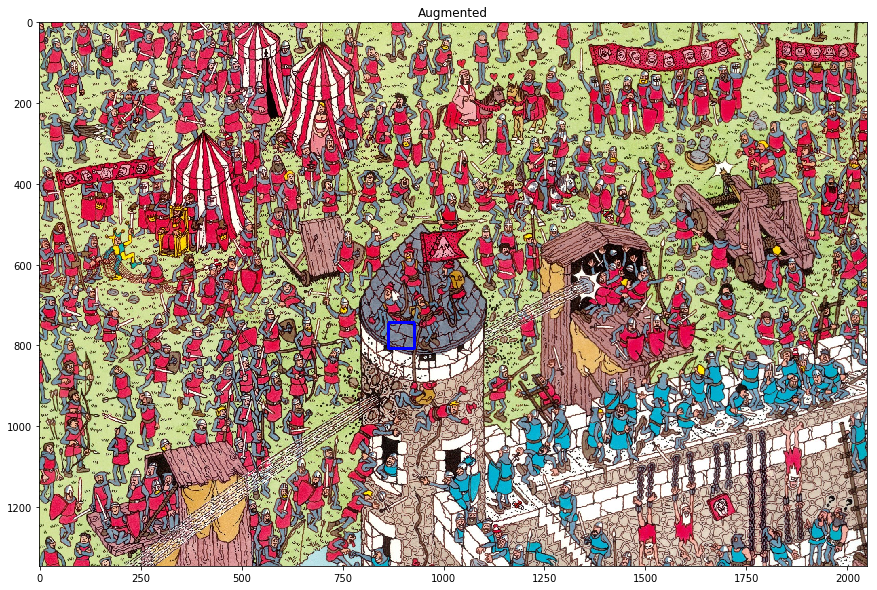

In [39]:
from matplotlib import pyplot as plt

annotated = locate()

plt.figure(figsize=(16, 10))
plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
inceptionV3 = InceptionV3(include_top=False, pooling='max')

In [30]:
x=inceptionV3.output
x=Dense(120,activation='softmax')(x)
preds=Dense(1,activation='softmax')(x)
transfer_model=Model(inputs=inceptionV3.input,outputs=preds)

In [31]:
for layer in transfer_model.layers[:-2]:
    layer.trainable=False
transfer_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [32]:
import glob
import cv2

wallies = glob.glob("Data/64/waldo/*.jpg")
not_wallies = glob.glob("Data/64/notwaldo/*.jpg")

Y = np.concatenate([np.ones(len(wallies)*10), np.zeros(len(not_wallies))-1])

X = []
for name in wallies:    
    wallie =  cv2.resize(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB),(299,299))
    flip_wallie = cv2.flip(wallie, 1)
    blur_wallie = cv2.GaussianBlur(wallie, (3,3), 2)
    blur_flip_wallie = cv2.GaussianBlur(flip_wallie, (3, 3), 2)
    dif_blur = cv2.blur(wallie, (3,3))
    dif_blur_flip = cv2.flip(dif_blur, 1)
    X.append(wallie)
    X.append(flip_wallie)
    X.append(blur_wallie)
    X.append(blur_flip_wallie)
    X.append(dif_blur)
    X.append(dif_blur_flip)
    X.append(cv2.medianBlur(wallie, 3))
    X.append(cv2.medianBlur(flip_wallie, 3))
    X.append(cv2.bilateralFilter(wallie, 5, 25, 25))
    X.append(cv2.bilateralFilter(flip_wallie, 5, 25, 25))
for name in not_wallies:    
    X.append(cv2.resize(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB),(299,299)))
X = np.array(X)

In [33]:
transfer_model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

transfer_model.fit(x=X,y=Y,epochs=3)

Epoch 1/3
5727/5727 [==============================] - 691s 121ms/step - loss: 29.7135 - acc: 0.0681
Epoch 2/3
5727/5727 [==============================] - 664s 116ms/step - loss: 29.7135 - acc: 0.0681
Epoch 3/3
5727/5727 [==============================] - 721s 126ms/step - loss: 29.7135 - acc: 0.0681


In [36]:
def locate():
    data = cv2.cvtColor(cv2.imread('Data/original-images/1.jpg'), cv2.COLOR_BGR2RGB)
    
    heatmap = transfer_model.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    plt.figure(figsize=(16, 10))
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Potential Wally matches")
    plt.figure(figsize=(16, 10))
    plt.show()
    maximum = np.max(heatmap)
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]> maximum - 0.0001])
    y = (yy[heatmap[0,:,:,0]>maximum - 0.0001])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

In [37]:
from matplotlib import pyplot as plt

annotated = locate()

plt.figure(figsize=(16, 10))
plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

IndexError: too many indices for array

<Figure size 1152x720 with 0 Axes>